# **2. Illustrative Example: Predicting Risk of Ischemic Stroke**


In [630]:
import pandas as pd
import pyreadr
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

from itertools import combinations

# sklearn and scipy imports
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.dummy import DummyClassifier
from scipy.stats import ttest_ind, pearsonr, chi2, chi2_contingency

# preprocessing imports
from sklearn.preprocessing import PowerTransformer, PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  RocCurveDisplay

# visualization, display and printing
from matplotlib.pyplot import figure
from IPython.display import display, Math

# ggplot layers
from plotnine import (ggplot, aes, geom_point, geom_bar, geom_density, scale_fill_manual, theme,
                      geom_boxplot, geom_histogram, ggtitle, facet_wrap, xlab, ylab, geom_text)

# for setting plot size mainly
import plotnine.options as ggplot_options

%matplotlib inline

In [593]:
stroke_data = pyreadr.read_r("./data/Ischemic_Stroke/stroke_data.RData")

# train and test sets
stroke_train_df = stroke_data['stroke_train']
stroke_test_df = stroke_data['stroke_test']

# response
y_train = stroke_train_df['Stroke']

# VascuCap software generated predictors
VC_PREDICTORS = [
  'CALCVol', 'CALCVolProp', 'MATXVol', 'MATXVolProp', 'LRNCVol', 
  'LRNCVolProp', 'MaxCALCArea', 'MaxCALCAreaProp', 'MaxDilationByArea', 
  'MaxMATXArea', 'MaxMATXAreaProp', 'MaxLRNCArea', 'MaxLRNCAreaProp', 
  'MaxMaxWallThickness', 'MaxRemodelingRatio', 'MaxStenosisByArea', 
  'MaxWallArea', 'WallVol', 'MaxStenosisByDiameter'
]

# those predictors are probably surveyed
RISK_PREDICTORS = [
  'age', 'sex', 'SmokingHistory', 'AtrialFibrillation', 'CoronaryArteryDisease', 
  'DiabetesHistory', 'HypercholesterolemiaHistory', 'HypertensionHistory'
]

stroke_train_df['Stroke'].value_counts(normalize=True)

Y    0.505618
N    0.494382
Name: Stroke, dtype: float64

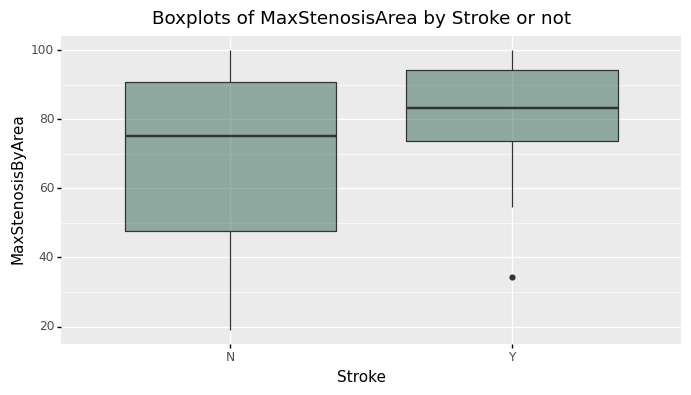

<ggplot: (323555295)>

In [594]:
ggplot_options.figure_size = (8, 4)

(ggplot(stroke_train_df) +
    aes(x='Stroke', y='MaxStenosisByArea') +
    geom_boxplot(fill='#336655', alpha=0.5) +
    ggtitle("Boxplots of MaxStenosisArea by Stroke or not")
)

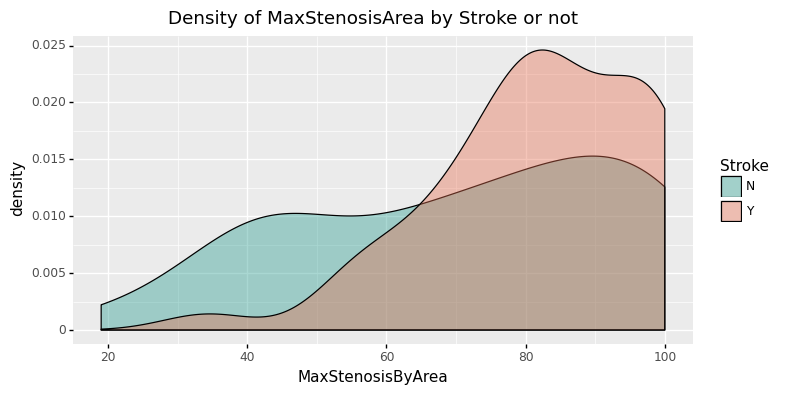

<ggplot: (323375520)>

In [599]:
(ggplot(stroke_train_df) +
    aes(x='MaxStenosisByArea', fill='Stroke') +
    geom_density(alpha=0.4) +
    ggtitle("Density of MaxStenosisArea by Stroke or not") +
    scale_fill_manual(values=["#2a9d8f", "#e76f51"])
)

#### Testing whether the distributions for <u>max_stenosis_by_area</u> for stroke and no stroke are the same

In [614]:
has_stroke = stroke_train_df['Stroke'] == 'Y'
max_stenosis_by_area = stroke_train_df['MaxStenosisByArea']

max_sten_pvalue = ttest_ind(
    max_stenosis_by_area[has_stroke],
    max_stenosis_by_area[~has_stroke],
    equal_var=False,
    alternative='greater'
).pvalue

corr, _ = pearsonr(stroke_train_df['MaxStenosisByArea'], stroke_train_df['MaxStenosisByDiameter'])

print("The correlation between MaxStenosisByArea and MaxStenosisByDiameter is {:.2f}".format(corr))

print("-------------------------------------------------------------------------------------------")

print(
    """There's a statistically significant difference between the distributions of MaxStenosisByDiameter,
      with a pvalue={:.2f}""".format(max_sten_pvalue)
)


The correlation between MaxStenosisByArea and MaxStenosisByDiameter is 0.94
-------------------------------------------------------------------------------------------
There's a statistically significant difference between the distributions of MaxStenosisByDiameter,
      with a pvalue=0.01


There's high correlation between <u>MaxStenosisByArea</u> and <u>MaxStenosisByDiameter</u> which is to be expected since area is a function of diameter.
Maybe for modelling only one of the predictors might be useful.

### **Description on some of the variables**

* CALCVol - calcified plaque volume
* LRNCVol - Lipid Rich Necrotic Core plaque volume
* MaxCALCArea - area of CALC
* MaxLRNCArea - area of LRNC
* MaxStenosisByDiameter
* MaxRemodelingRatio - Remodeling ratio is a measure of the arterial wall where ratios less than 1 indicate a wall shrinkage and ratios greater than 1 indicate wall growth. This metric is likely important because coronary arteries with large ratios like the one displayed here have been associated with rupture (Cilla et al. 2013; Abdeldayem et al. 2015). 


|       | Stroke = No | Stroke = Yes     |
| :---        |    :----:   |          ---: |
| Blockage < 70%      | 43       | 39   |
| Blockage > 70%   | 19        | 25      |

Let's use the $\chi^2$ test for independence, first by hand.

In [616]:
observed = np.array([[43, 39], [19, 25]])
n = observed.sum()

x_marginal = observed.sum(axis=1) / n
y_marginal = observed.sum(axis=0) / n

expected = n * np.matmul(x_marginal.reshape(-1, 1), y_marginal.reshape(1, -1))

# using yates correction
chsq_stat = ((np.abs((observed - expected)) - 0.5) ** 2 / expected).sum()
pval = (1 - chi2.cdf(chsq_stat, df=1))

print("Chisq-test for indpendence with pvalue={:.2f}".format(pval))

Chisq-test for indpendence with pvalue=0.42


Or simply by using the chisq independence test

In [619]:
# or simply by using the chisq test for independence
_, pval, *_ = chi2_contingency(observed)
print("pvalue={:.2f}".format(pval))

pvalue=0.42


We can see that we cannot reject independence between Stroke and Blockage above 70%, even though that has been the historical requirement for surgical intervention.

The association between blockage categorization and stroke outcome is provided in Table 2.1. For these patients, the association is not statistically significant based on a chi-squared test of association (p = 0.42), indicating that blockage categorization alone is likely not a good predictor of stroke outcome.

<br /><br />

## **2.2 Preprocessing**

One of the first steps of the modeling process is to understand important predictor characteristics such as their individual distributions, the degree of missingness within each predictor, potentially unusual values within predictors, relationships between predictors, and the relationship between each predictor and the response and so on.

#### **Explore missing data**

In [618]:
(stroke_train_df[['Stroke']]
 .assign(data='train')
 .append(stroke_test_df[['Stroke']].assign(data='test'))
 .groupby(['data', 'Stroke'])
 .size()
 .reset_index()
 .pivot_table(index='data', columns='Stroke')
 .set_axis(['No', 'Yes'], axis=1)
)

,No,Yes
data,,
test,18,19
train,44,45


### **Individual Distributions of Predictors**

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


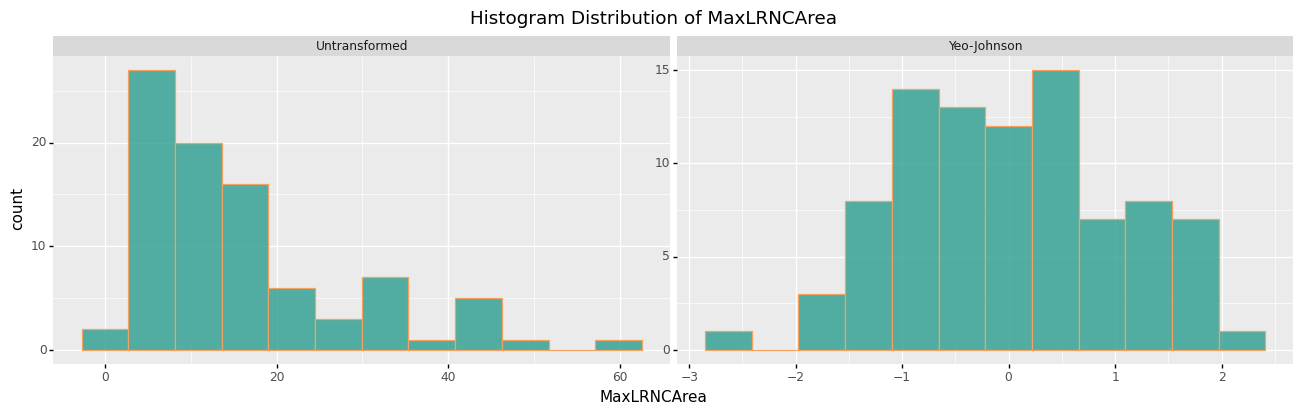

<ggplot: (325406585)>

In [620]:
ggplot_options.figure_size = (16, 4)

power_transformer = PowerTransformer(method='yeo-johnson')

transformed_arr = power_transformer.fit_transform(stroke_train_df[['MaxLRNCArea']])
transformed_df = pd.DataFrame(transformed_arr, columns=['MaxLRNCArea'])

(stroke_train_df[['MaxLRNCArea']]
 .assign(type='Untransformed')
 .append(transformed_df[['MaxLRNCArea']].assign(type='Yeo-Johnson'))
 .pipe(ggplot) +
    aes(x='MaxLRNCArea', fill='type') +
    geom_histogram(fill='#2a9d8f', color='#f4a261', alpha=0.8, bins=12) +
    ggtitle("Histogram Distribution of MaxLRNCArea") +
    facet_wrap('type', scales='free')
)

This kind of transformation makes sense for measurements that increase exponentially. Here, the lipid area naturally grows multiplicatively by definition of how areas is calculated.



MaxLRNCArea is a measurement of the mixture of lipid pools and necrotic cellular debris for a cross-section of the stenosis.


there are three pairs of predictors that show unacceptably high correlations:

* vessel wall volume in $mm^3$
* (WallVol) and matrix volume (MATXVol), maximum cross-sectional wall area in  $mm^2$
* (MaxWallArea) and maximum matrix area (MaxMATXArea)
* maximum cross-sectional stenosis based on area (MaxStenosisByArea) and maximum cross-sectional stenosis based on diameter (MaxStenosisByDiameter)

Text(0.5, 1.0, 'Correlation Heatmap')

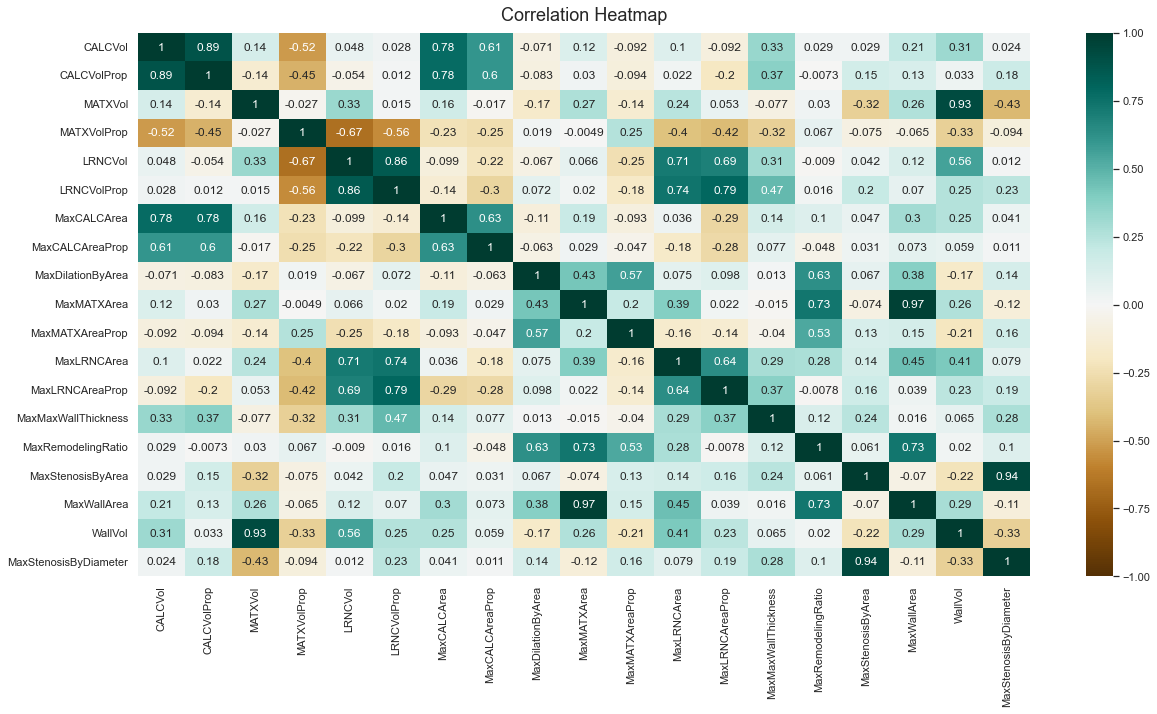

In [623]:
sns.set(rc={'figure.figsize': (20, 10)})

heatmap = sns.heatmap(stroke_train_df[VC_PREDICTORS].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=12)

We establish the following correlations:

* cor(MATXVol, WallVol) = 0.93
* cor(CALCVol, CALCVolProp) = 0.89
* cor(MaxStenosisByArea, MaxStenosisByDiameter) = 0.94
* cor(MaxMatxArea, MaxWallArea) = 0.97


Next, we will remove predictors that are highly correlated ( r > 0.9) with other predictors. The correlation among the imaging predictors can be visually seen in the heatmap in Figure 2.3 where the order of the columns and rows are determined by a clustering algorithm. Here, there are three pairs of predictors that show unacceptably high correlations:

* vessel wall volume in  mm3 (WallVol) and matrix volume (MATXVol),
* maximum cross-sectional wall area in  mm2 (MaxWallArea) and maximum matrix area (MaxMATXArea)
* maximum cross-sectional stenosis based on area (MaxStenosisByArea) and maximum cross-sectional stenosis based on diameter (MaxStenosisByDiameter).


<br/>

## **2.3 Exploration**
The next step is to explore potential predictive relationships between individual predictors and the response and between pairs of predictors and the response.

when we want to compare two models ($M_1$ and $M_2$), the following procedure, discussed more in Section 3.7, will be used:

![Tux, the Linux mascot](./images/algo-model-compare.png)

The Repated cross-validation makes a 10-fold cross validation 5 times.

In [624]:
RANDOM_STATE = 2

dummy_clf = DummyClassifier(random_state=RANDOM_STATE, strategy='most_frequent')
lr_clf = LogisticRegression(fit_intercept=True, penalty='none')

def get_model_improve(df, model, response, random_state=1):
    dummy = DummyClassifier(random_state=random_state, strategy='most_frequent')
    rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=random_state)

    # scores of the model and the dummy model
    m1_scores = cross_val_score(model, df, response, cv=rkf, scoring='roc_auc')
    m2_scores = cross_val_score(dummy, df, response, cv=rkf, scoring='roc_auc')

    # get mean roc score for the improved model, mean improvement and the pvalue
    roc = m1_scores.mean()
    improvement = (m1_scores - m2_scores).mean()
    pval = ttest_ind(m1_scores, m2_scores, alternative='greater').pvalue

    return df.columns[0], roc, improvement, pval

In [626]:
ALL_PREDS = VC_PREDICTORS + RISK_PREDICTORS
# get improvement metrics for all of the different variables
CMP_RESULT_COLS = ['variable', 'roc', 'improvement', 'pvalue']

results = [get_model_improve(stroke_train_df[[feat]], lr_clf, stroke_train_df['Stroke']) for feat in ALL_PREDS]

results_df = pd.DataFrame(results, columns=CMP_RESULT_COLS).sort_values(by='improvement', ascending=False)
results_df.head(3)


,variable,roc,improvement,pvalue
13,MaxMaxWallThickness,0.728401,0.228401,2.653304e-12
14,MaxRemodelingRatio,0.670770,0.170770,7.869521e-11
18,MaxStenosisByDiameter,0.632548,0.132548,1.881134e-05


Boxplots with the different numeric predictors.

In [477]:
ggplot_options.figure_size = (12, 8)

pt = PowerTransformer(method='yeo-johnson')
vc_stroke_train_df = stroke_train_df[VC_PREDICTORS]

vc_stroke_train_scaled_df = pd.DataFrame(
    pt.fit_transform(vc_stroke_train_df),
    columns=vc_stroke_train_df.columns
)

# reproduce the boxplots from the book
boxplots_plt = (vc_stroke_train_scaled_df
 .assign(Stroke=stroke_train_df['Stroke'])
 .melt(id_vars='Stroke')
 .pipe(ggplot) +
    # TODO: it misses pvalues like in the book
    aes(x='Stroke', y='value') +
    geom_boxplot(fill='#336622', alpha=0.4) +
    facet_wrap('variable')
)

# show by uncommenting next line
# boxplots_plt

At this point best features seem to be MaxMaxWallThickness and MaxRemodelingRatio. Let's see how a ROC curve would look for the MaxRemodelingRatio.

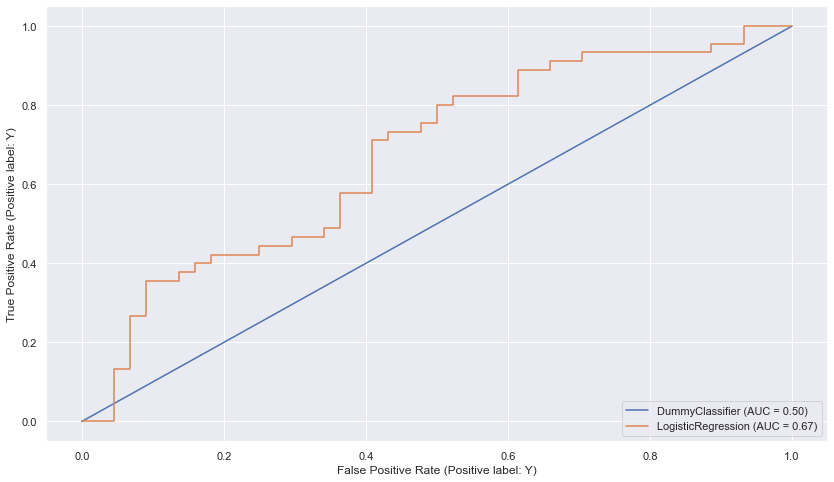

In [628]:
# change the plot size
sns.set(rc={'figure.figsize':(14, 8)})

# create logistic regression and a dummy model
lr = LogisticRegression(penalty='none')
dc = DummyClassifier(strategy='most_frequent')

# fit them
lr.fit(vc_stroke_train_scaled_df[['MaxRemodelingRatio']], stroke_train_df['Stroke'])
dc.fit(vc_stroke_train_scaled_df[['MaxRemodelingRatio']], stroke_train_df['Stroke'])

# plot the base line dummy model
ax = RocCurveDisplay.from_estimator(dc, vc_stroke_train_scaled_df[['MaxRemodelingRatio']], stroke_train_df['Stroke']).ax_

# plot the improved MaxRemodelingRatio model
RocCurveDisplay.from_estimator(lr, vc_stroke_train_scaled_df[['MaxRemodelingRatio']], stroke_train_df['Stroke'], ax=ax)

## **Exploring Interactions**

In [629]:
def interactize_frame(df, poly_tr):
    """returns a dataframe using a poly transformer so that intercations are obtained"""
    transformed_arr = poly_tr.fit_transform(df)
    columns = poly_tr.get_feature_names_out(df.columns)
    return pd.DataFrame(transformed_arr, columns=columns)

def compare_models(df1, df2, response, rkf):
    """compare two models, one on two of the predictors, and another with the interaction"""
    model1 = LogisticRegression(penalty='none')
    model2 = LogisticRegression(penalty='none')

    # scores of the model and the dummy model
    m1_scores = cross_val_score(model1, df1, response, cv=rkf, scoring='roc_auc')
    m2_scores = cross_val_score(model2, df2, response, cv=rkf, scoring='roc_auc')

    # get mean roc score for the improved model, mean improvement and the pvalue from a t.test
    roc = m1_scores.mean()
    improvement = (m1_scores - m2_scores).mean()
    pval = ttest_ind(m1_scores, m2_scores, alternative='greater').pvalue

    return df2.columns[2], roc, improvement, pval

# generate all kind of combinations of the features
feature_combinations = np.asarray(list(combinations(VC_PREDICTORS, 2)))
rkf = RepeatedKFold(n_splits=10, n_repeats=5)
poly_transformer = PolynomialFeatures(interaction_only=True, include_bias = False)

# dataframes of all combinations 
combo_frames = [vc_stroke_train_scaled_df[combo] for combo in feature_combinations]
# dataframes of combinations and added interactions
interact_frames = [interactize_frame(df, poly_transformer) for df in combo_frames]

int_results_arr = [compare_models(cdf, idf, y_train, rkf) for cdf, idf in zip(combo_frames, interact_frames)]
int_results_df = pd.DataFrame(int_results_arr, columns=CMP_RESULT_COLS)

/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:771: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 762, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/Users/nikolashahpazov/.pyenv/versions/3.9.2/lib/python3.9/site-packages/sklearn/metrics/_ranking.py", line 566, in roc_auc_score
    r

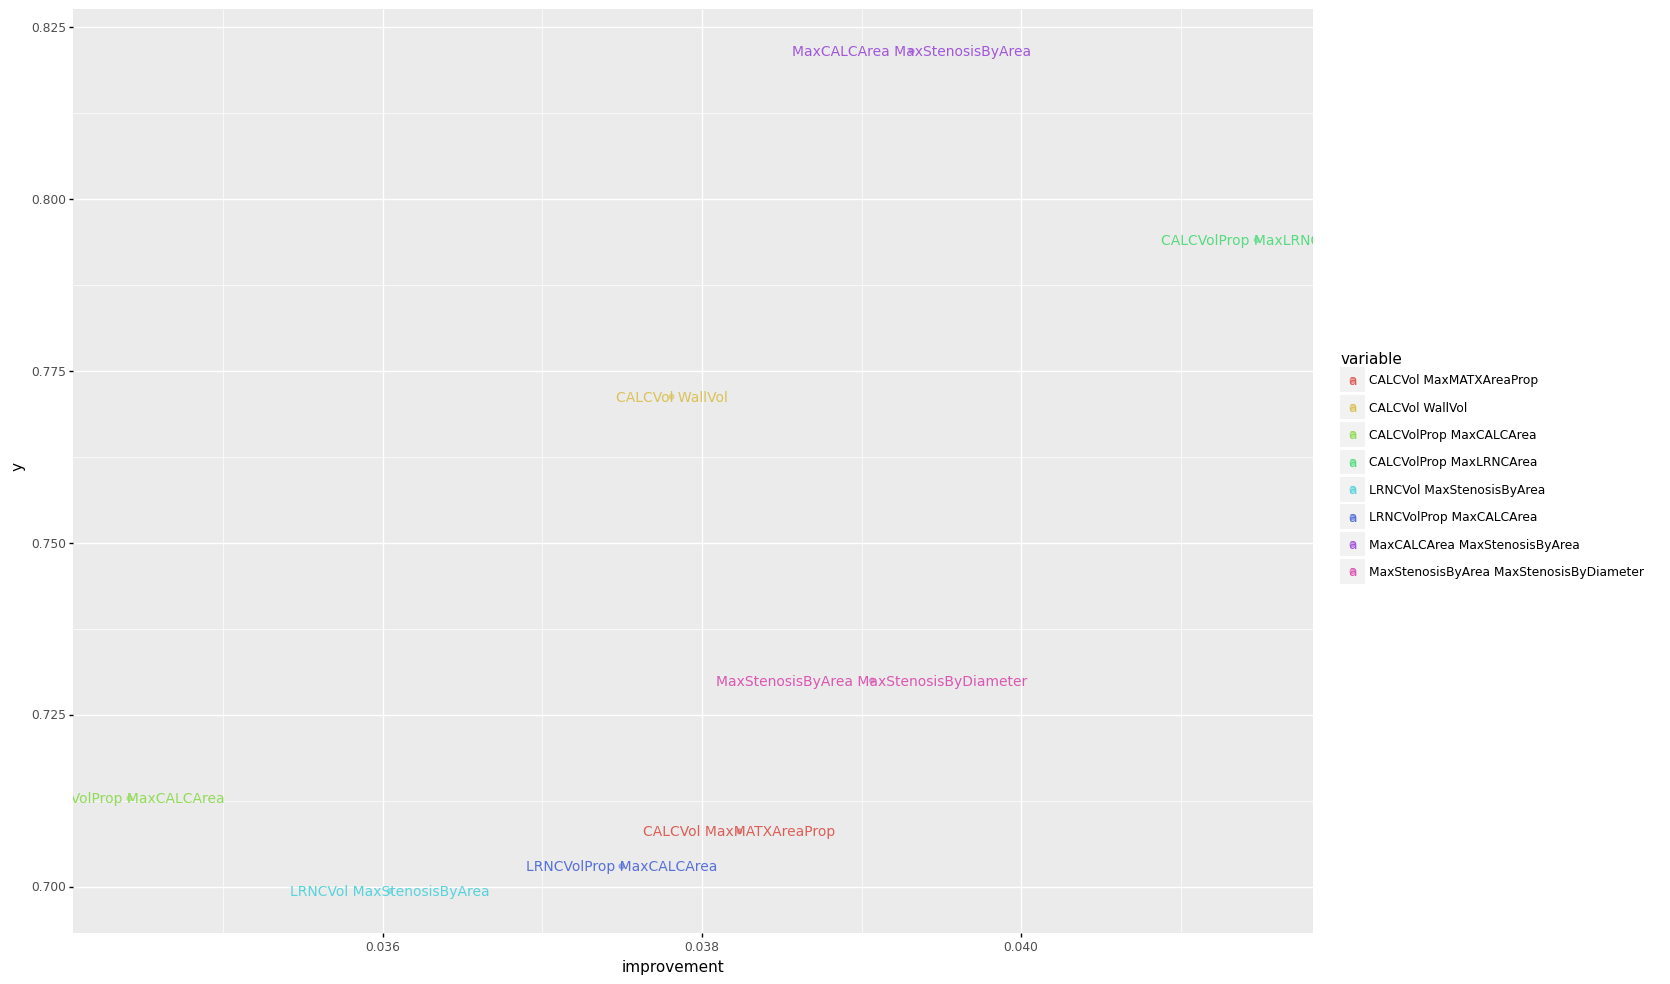

<ggplot: (323957788)>

In [638]:
ggplot_options.figure_size = (16, 12)

(int_results_df[(int_results_df['roc'] > 0.5) & (int_results_df['pvalue'] < 0.2)]
 .sort_values(by='improvement')
 .head(8)
 .assign(y=lambda x: -np.log10(x['pvalue']))
 .pipe(ggplot) +
    aes(x='improvement', y='y', color='variable') +
    geom_point(alpha=0.5) +
    geom_text(aes(label='variable'), size=10)
)

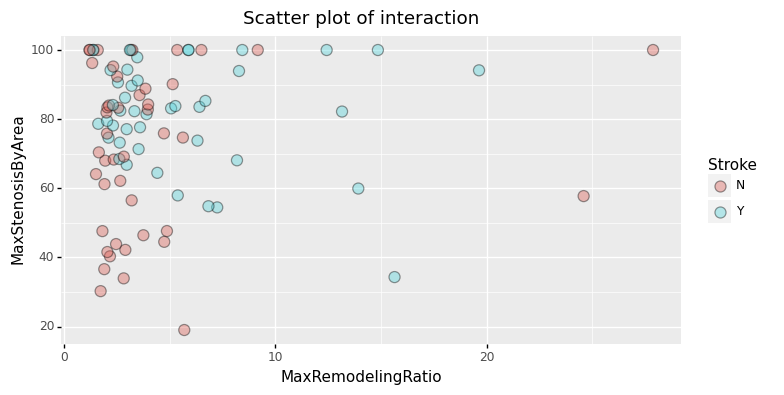

<ggplot: (324576829)>

In [647]:
ggplot_options.figure_size = (8, 4)

(ggplot(stroke_train_df) +
    aes(x='MaxRemodelingRatio', y='MaxStenosisByArea', fill='Stroke') +
    geom_point(size=4, alpha=0.4) +
    ggtitle("Scatter plot of interaction")
)

Testing for whether there is significant difference of MaxRemodelingRatio * MaxStenosisByArea with a t.test
pvalue = 0.07


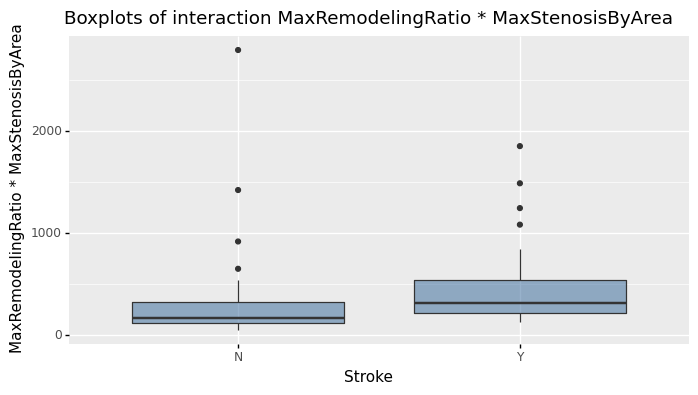

<ggplot: (323470114)>

In [660]:
interaction = stroke_train_df['MaxRemodelingRatio'] * stroke_train_df['MaxStenosisByArea']

pval = ttest_ind(interaction[y_train == 'Y'], interaction[y_train == 'N'], alternative='greater').pvalue

print("Testing for whether there is significant difference of MaxRemodelingRatio * MaxStenosisByArea with a t.test")
print("pvalue = {:.2f}".format(pval))

(stroke_train_df
 .assign(mrr_msba_int=interaction)
 .pipe(ggplot) +
    aes(x='Stroke', y='mrr_msba_int') +
    geom_boxplot(fill='#336699', alpha=0.5) +
    ylab("MaxRemodelingRatio * MaxStenosisByArea") +
    ggtitle("Boxplots of interaction MaxRemodelingRatio * MaxStenosisByArea")
)
